In [1]:
import collections
import os
import pickle
import sys
import time

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from snmachine import snaugment, sndata
from snmachine.utils.plasticc_pipeline import get_directories, load_dataset, create_folder_structure

In [4]:
%config Completer.use_jedi = False  

In [5]:
%matplotlib inline

sns.set(font_scale=1.3, style="ticks")

In [7]:
folder_path = 'C:\\Users\\Alcatraz\\Desktop\\Supernova\\snmachine-main\\snmachine\\example_data'

In [8]:
data_file_name = 'example_dataset_gapless50.pckl'

In [9]:
data_path = os.path.join(folder_path, data_file_name)
dataset = load_dataset(data_path)

Opening from binary pickle
Dataset loaded from pickle file as: <snmachine.sndata.PlasticcData object at 0x0000020F9676AC40>


In [10]:
analysis_name = data_file_name[:-5]

In [11]:
import os

def create_folder_structure(folder_path, analysis_name):

    for key, value in directories.items():
        os.makedirs(value, exist_ok=True)

folder_path = r'C:\Users\Alcatraz\Desktop\Supernova\snmachine-main\snmachine\example_data'

create_folder_structure(folder_path, analysis_name)


NameError: name 'directories' is not defined

In [12]:
directories = get_directories(folder_path, analysis_name) 
path_saved_gps = directories['intermediate_files_directory']

In [13]:
aug_obj_names = dataset.object_names  

In [14]:
np.random.seed(42)
is_to_aug = np.in1d(dataset.object_names, aug_obj_names)

target_number_aug = np.sum(is_to_aug) * 2

number_objs_per_label = collections.Counter(dataset.labels[is_to_aug])
number_aug_per_label = target_number_aug//len(number_objs_per_label.keys())
objs_number_to_aug = {}
for label in number_objs_per_label.keys():
    is_label = dataset.labels[is_to_aug] == label
    aug_is_label_obj_names = aug_obj_names[is_label]
    number_aug_per_obj = number_aug_per_label // np.sum(is_label)
    number_extra_aug_per_obj = number_aug_per_label % np.sum(is_label)
    extra_obj = np.random.choice(aug_is_label_obj_names, size=number_extra_aug_per_obj, 
                                 replace=False)
    objs_number_to_aug.update({obj: number_aug_per_obj for obj in aug_is_label_obj_names})
    objs_number_to_aug.update({obj: number_aug_per_obj+1 for obj in extra_obj})

In [15]:
print(f'We aim to create up to {sum(objs_number_to_aug.values())} events.')  

We aim to create up to 180 events.


In [16]:
test_data_file_name = 'example_test_dataset.pckl'
test_data_path = os.path.join(folder_path, test_data_file_name)

test_data = load_dataset(test_data_path)
test_metadata = test_data.metadata


z_table = test_metadata[test_metadata.hostgal_specz > -2]

Opening from binary pickle
Dataset loaded from pickle file as: <snmachine.sndata.PlasticcData object at 0x0000020F8F9EC1C0>


In [17]:
print(f'The longest event in `dataset` has {dataset.get_max_length():.2f} days.')

The longest event in `dataset` has 271.56 days.


In [18]:
random_seed = 42 
max_duration = 278

In [19]:
aug = snaugment.PlasticcWFDAugment(dataset=dataset, path_saved_gps=path_saved_gps, 
                                   objs_number_to_aug=objs_number_to_aug,
                                   random_seed=random_seed, max_duration=max_duration, 
                                   z_table=z_table)

In [20]:
aug.augment()

Augmenting the dataset...
Time spent augmenting: 0 days 00:00:21.


In [21]:
try:  
    test_metadata['target'] = test_metadata['true_target']
    datasets_label = ['Original', 'Only Aug.', 'Test data']
    datasets_metadata = [aug.dataset.metadata, aug.only_new_dataset.metadata, test_metadata]
except NameError:   
    datasets_label = ['Original', 'Only Aug.']
    datasets_metadata = [aug.dataset.metadata, aug.only_new_dataset.metadata]

In [22]:
print(f'The longest event in the augmented dataset (`aug.only_new_dataset`)'
      f' has {aug.only_new_dataset.get_max_length():.2f} days.')

The longest event in the augmented dataset (`aug.only_new_dataset`) has 268.10 days.


In [23]:
print(f'In total we generated {len(aug.only_new_dataset.object_names)} events.')

In total we generated 62 events.


In [24]:
print('{:^12}  {:^12}  {:^12}  {:^12}'.format('Dataset', 'total # objs', '# DDF objs', '% DDF objs'))
print('-'*(12*4 + 3*2))
for i in np.arange(len(datasets_label)):
    is_ddf = datasets_metadata[i]['ddf'] == 1
    number_total_objs = len(is_ddf)
    number_ddf_objs = np.sum(is_ddf)
    print('{:^12} {:^12} {:^12} {:^12.2f}'.format(
        datasets_label[i], number_total_objs, number_ddf_objs, 
        number_ddf_objs/number_total_objs * 100))

  Dataset     total # objs   # DDF objs    % DDF objs 
------------------------------------------------------
  Original        90           23         25.56    
 Only Aug.        62           0           0.00    
 Test data       5000          0           0.00    


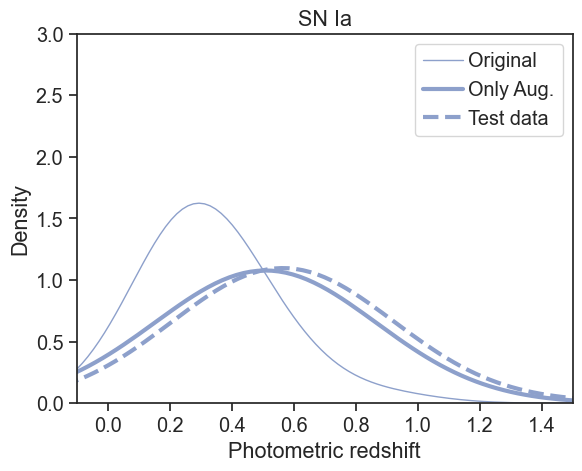

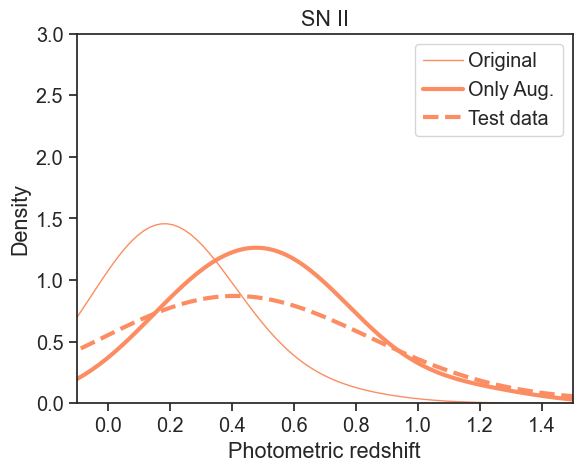

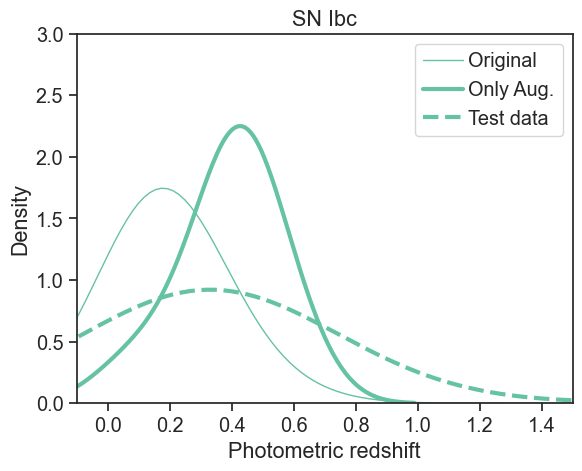

In [25]:

diverg_color = sns.color_palette("Set2", 3, desat=1)
sn_type_color = {42: diverg_color[1], 62: diverg_color[0], 90: diverg_color[2]}
sn_type_name = {42: 'SN II', 62: 'SN Ibc', 90: 'SN Ia'}
unique_types = [90, 42, 62]
datasets_ls = ['-', '-', '--']
datasets_linewidth = [1, 3, 3]
datasets_bw_adjust = [.3, .8, .8]

for sn_type in unique_types:
    plt.figure()
    for i, metadata in enumerate(datasets_metadata):
        label = datasets_label[i]
        ls = datasets_ls[i]
        linewidth = datasets_linewidth[i]
        bw_adjust= datasets_bw_adjust[i]
        is_sn_type = (metadata['target'] == sn_type)
        sn_type_metadata = metadata[is_sn_type]
        try:
            sns.kdeplot(data=sn_type_metadata['hostgal_photoz'],
                        label=label, color=sn_type_color[sn_type],
                        linestyle=ls, linewidth=linewidth, 
                        bw=bw_adjust)
        except ValueError:  
            sns.distplot(a=sn_type_metadata['hostgal_photoz'], 
                         label=label, color=sn_type_color[sn_type],
                         kde_kws={'linestyle': ls, 
                                  'linewidth': linewidth})
    sn_name = sn_type_name[sn_type]
    plt.title(sn_name)
    plt.xlim(-.1, 1.5)
    plt.ylim(0, 3)
    plt.xlabel('Photometric redshift')
    plt.ylabel('Density')
    plt.legend(handletextpad=.3)

In [26]:
folder_path_to_save = folder_path
file_name = 'example_dataset_aug.pckl'

In [27]:
only_aug_dataset = aug.only_new_dataset

path_to_save = os.path.join(folder_path_to_save, file_name)
with open(path_to_save, 'wb') as f:
    pickle.dump(only_aug_dataset, f, pickle.HIGHEST_PROTOCOL)

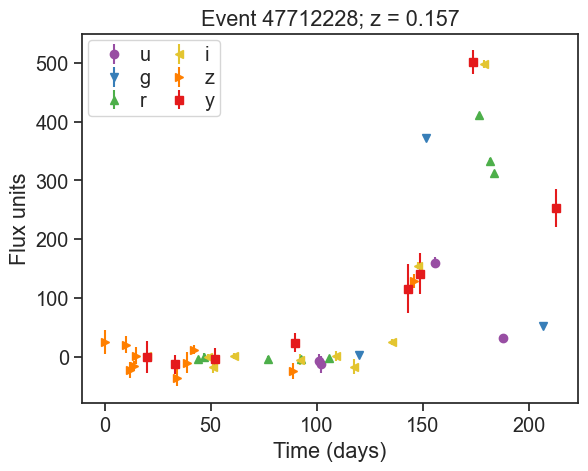

In [28]:
obj_show = '47712228'
sndata.PlasticcData.plot_obj_and_model(dataset.data[obj_show])
plt.title(f'Event {obj_show}; z = {dataset.metadata.loc[obj_show, "hostgal_specz"]:.3f}');

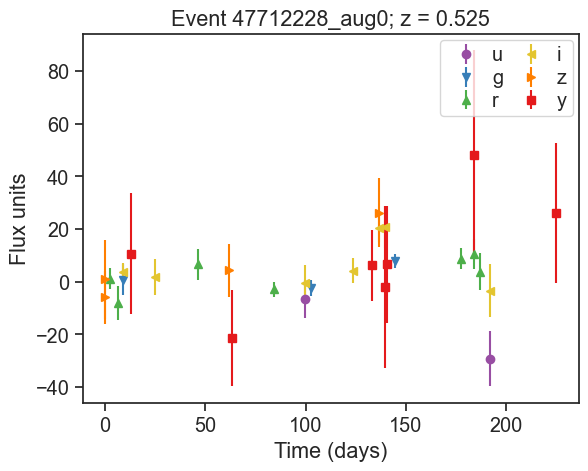

In [29]:
obj_aug_show = obj_show + '_aug0'
sndata.PlasticcData.plot_obj_and_model(only_aug_dataset.data[obj_aug_show])
plt.title(f'Event {obj_aug_show}; z = {only_aug_dataset.metadata.loc[obj_aug_show, "hostgal_specz"]:.3f}');